<a href="https://colab.research.google.com/github/emali1/Mastering-Keras/blob/master/Module_2_2__CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 2.2: Working with CNNs in Keras (A Review)

We turn to implementing a CNN in the Keras functional API. In this module we will pay attention to:
1. Using the Keras functional API for defining models.
2. Implementing dropout regularization.

Those students who are comfortable with all these matters might consider skipping ahead.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

We start by importing required libraries.

In [12]:
import numpy as np

from sklearn.metrics import confusion_matrix,classification_report

from keras.datasets import cifar10
from keras.models import Sequential
from keras import Model
from keras.layers import Dense,Dropout,Flatten,Activation,Input
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

import matplotlib.pyplot as plt

We will use the CIFAR10 dataset. This consists of small (32 x 32 pixel) color images of 10 different types of objects. It is included in the keras.datasets library.

We load the images. These are already split into training and test cases. We need to normalize the pixel values to be between 0 and 1, and turn our integer labels into one-hot vectors - these are 1d-arrays of length the same as the number of classes, with zeros everywhere except the label specified, which is a 1. They are the probability that the image is of different classes.

We also make a vector of class/label names for display purposes, as the label arrays contain only integers.

In [13]:
# Load images
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Make versions of the labels that are one-hot vectors
train_labels_array=np_utils.to_categorical(train_labels, 10)
test_labels_array=np_utils.to_categorical(test_labels, 10)

# Make vector of classnames
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
train_labels_array.shape

(50000, 10)

Let's make a function to have a look at the images.

In [15]:
def show_images(images,labels,class_names,random=True):
  plt.figure(figsize=(10,10))
  if random:
    indices=np.random.randint(0,images.shape[0],25)
  else:
    indices=np.array([i for i in range(25)])
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[indices[i]], cmap=plt.cm.binary)
      # The CIFAR labels happen to be arrays, 
      # which is why we need the extra index
      plt.xlabel(class_names[labels[indices[i]][0]])
  plt.show()

Now we run it. We will see 25 random images from the dataset that we pass. If you set random=False you will see the first 25 images, the variety of which reassures us that the data is in a random order. (If this was a real world problem, such re-assurances would be insufficient, and we would shuffle the data.)

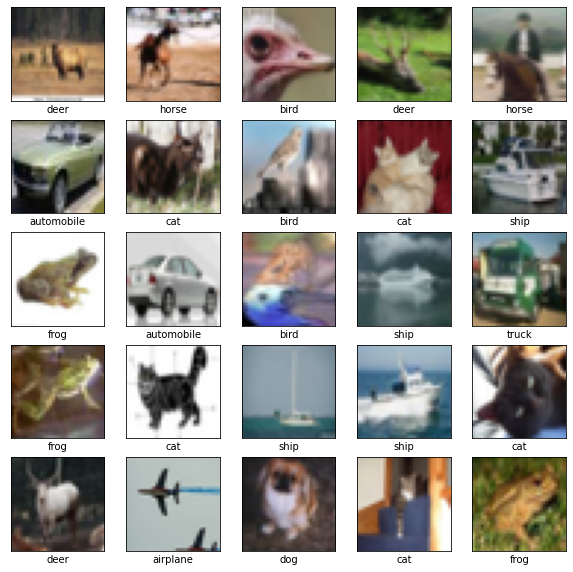

In [16]:
show_images(train_images,train_labels,class_names,True)

Now we create a function that will define the network architecture. Note that we introduce dropout layers for regularization purposes. We discussed these in the last module.

For comparison, the code to specify the same network using the sequential approach is provided in a second function.

In [17]:
def get_model():
  inputs = Input(shape=(32, 32, 3),name="Input")
  conv1 = Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))(inputs)
  pool1 = MaxPooling2D((2, 2))(conv1)
  drop1 = Dropout(0.5)(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu')(drop1)
  pool2 = MaxPooling2D((2, 2))(conv2)
  drop2 = Dropout(0.5)(pool2)
  conv3 = Conv2D(64, (3, 3), activation='relu')(drop2)
  flat = Flatten()(conv3)
  dense1 = Dense(64, activation='relu')(flat)
  outputs = Dense(10, activation='softmax')(dense1)
  model = Model(inputs=inputs,outputs=outputs)
  return model

# # For comparison, this is how we would use the sequential process
# def get_model_seqential():
#   model = Sequential()
#   model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
#   model.add(MaxPooling2D((2, 2)))
#   model.add(Dropout(0.5))
#   model.add(Conv2D(64, (3, 3), activation='relu'))
#   model.add(MaxPooling2D((2, 2)))
#   model.add(Dropout(0.5))
#   model.add(Conv2D(64, (3, 3), activation='relu'))
#   model.add(Flatten())
#   model.add(Dense(64, activation='relu'))
#   model.add(Dense(10, activation='softmax'))
#   return model

We will get our model.

In [18]:
model=get_model()

Now we will define an optimizer and compile it. If you are unfamiliar with the different types of optimizers available in keras, I suggest you read the keras documentation [here](https://keras.io/optimizers/) and play around training the model with different alternatives.

In [19]:
opt=Adam()

And we compile our model with the optimizer ready for training. We use categorical crossentropy as our loss function as this is a good default choice for working with a multi-class categorical target variable (i.e. the image labels).

In [20]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
import tensorflow as tf
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Now we fit (train) the model. We will set the training to continue for 100 epochs, but use an early stopping callback which means it should terminate much quicker than this.

In [11]:
# Before calling fit, we create the Early Stopping callback. 
# We set it up to stop if improvement in the validation loss 
# does not occur over 10 epochs. When stopping occurs, the 
# weights associated with the best validation loss are restored.
earlyStopping = EarlyStopping(monitor="val_loss", 
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)

# We need to use the one-hot vector version of the labels
# This shouldn't go through all 100 epoches, because of the
# early stopping, but can take some time.
history = model.fit(train_images, 
                    train_labels_array, 
                    epochs=100, 
                    shuffle=True, 
                    callbacks=[earlyStopping],
                    validation_split=.2)


Epoch 1/100
 344/1250 [=======>......................] - ETA: 39s - loss: 2.1621 - accuracy: 0.1890

KeyboardInterrupt: ignored

We will plot the training history to see a graphical representation of the training.

In [ ]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model accuracy and loss')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy','Validation Accuracy', 'Loss',
                'Validation Loss'], loc='upper right')
    plt.show()

In [ ]:
plot_training_history(history)

Finally, for fun lets see how our improved model performs on our test data. But remember that we have not spent any time or effort optimizing this model - for a real problem we would determine good values for the dropout regularization, as well as tune the architecture and optimizer.

We make a function that will show the confusion matrix, and then run it.

In [ ]:
def test_model(model,x,y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis=1)
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("Classification report:")
    print(classification_report(y, y_pred))

In [ ]:
test_model(model,test_images,test_labels)